In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import grad, jacobian
import nlopt
from matplotlib import pyplot as plt
from scipy import special, signal
mp.quiet(quietval=True)

Using MPI version 3.1, 1 processes


In [2]:
resolution = 10

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1.5,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

seed = 24
np.random.seed(seed)

Nx = 10
Ny = 10

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
rho_vector = 6*np.ones((Nx*Ny,))
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=2)),mode=1)
TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(-1,0,0),size=mp.Vector3(y=2)),mode=1)
ob_list = [TE0,TE_top]

def J(source,top):
    return npa.abs(top/source) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)

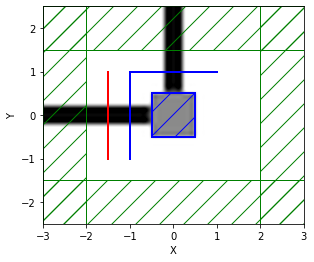

In [3]:
opt.plot2D(True)
plt.show()

## Method of Moving Asymptotes

In [4]:
evaluation_history = []
sensitivity = [0]
def f(x, grad):
    f0, dJ_deps, dg = opt([x])
    if grad.size > 0:
        grad[:] = np.squeeze(design_variables.get_basis_vjp(dJ_deps,dg))
    evaluation_history.append(np.real(f0))
    sensitivity[0] = dJ_deps
    return np.real(f0)

In [5]:
algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 30

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(1)
solver.set_upper_bounds(12)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)
x = solver.optimize(rho_vector);

[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6.]
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

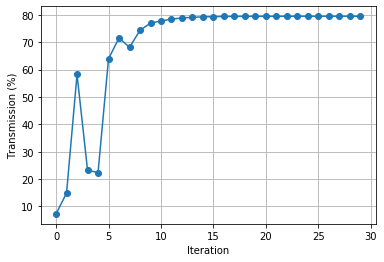

In [6]:
plt.figure()
plt.plot(np.array(evaluation_history)*100,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Transmission (%)')
plt.show()

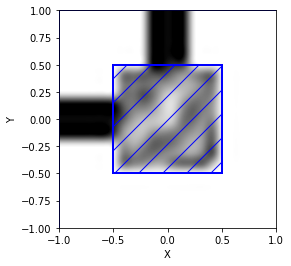

In [7]:
opt.update_design([x])
opt.plot2D(True,output_plane=mp.Volume(center=(0,0,0),size=(2,2,0)))

## Gradient Descent

In [8]:
num_epochs = 30
learning_rate = 15
momentum = 0.01
W = 6*np.ones((Nx*Ny,))
cur_dir = np.zeros((Nx*Ny,))
evaluation_history = []
for epoch in range(num_epochs):
    f0, dJ_deps, dg = opt([W])
    evaluation_history.append(f0)
    grad_W = np.squeeze(design_variables.get_basis_vjp(dJ_deps,dg))
    cur_dir = momentum * cur_dir + (1.0 - momentum) * grad_W
    W += learning_rate * cur_dir

Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating grad

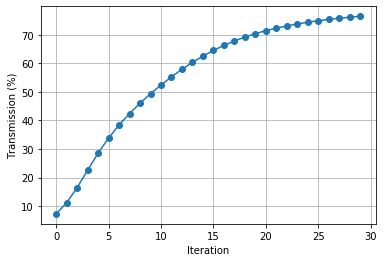

In [9]:
plt.figure()
plt.plot(np.array(evaluation_history)*100,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Transmission (%)')
plt.show()

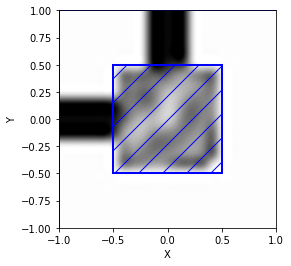

In [10]:
opt.update_design([W])
opt.plot2D(True,output_plane=mp.Volume(center=(0,0,0),size=(2,2,0)))